# CSC 373 / 673: Assignment 3

##### Author: Md Asifur Rahman
#### Acknowledgements: 
1. All the datasets were provided by Dr. Natalia Khuri
2. Some of the code snippets were taken from the earlier solutions provided by Dr. Natalia Khuri
3. The k-means implementation for categorical data (kmodes.py) has been taken from the github repository:  https://github.com/nicodv/kmodes and the following modifications were included to suit this project.
     - a. Change of internal validation metrics to WSSS.
     - b. Inclusion of external distance metrics from distance_metrics.py

In [4]:
import pandas as pd
import numpy as np
import my_utils
import clustering as clusterer
import file_processor 
import warnings
import os
import time
import matplotlib.pyplot as plt
import distance_metrics
from kmodes import *
from IPython.display import Image
%matplotlib inline
warnings.filterwarnings('ignore')

# 1. Minimum Performance

In [2]:
# define functions to prepare cycling data for modeling
def adjust_feature_types(dataset):
    dataset["timestamp"] = pd.to_datetime(dataset["timestamp"], utc=True)
    dataset = dataset.astype({'activity_id': 'category', 
                   'category_id': 'category', 
                   'athlete_id': 'category'})
    numeric_columns = dataset.select_dtypes('number').columns
    for column in numeric_columns:
        dataset = dataset.astype({column: 'float64'})
    return dataset

def prepare_cycling_data(file_path):
    dataset = pd.read_csv(file_path, index_col=None)
    print("# Before preproccessing no of instance:", dataset.shape[0])
    dataset = adjust_feature_types(dataset)
    dataset = file_processor.remove_outliers(dataset, num_std=3)
    dataset = file_processor.remove_features_near_zero_variance(dataset, threshold=1e-4)
    print("# After preproccessing retained instance:", dataset.shape[0])
    return dataset

## 1.1 Preprocessing the Cycling dataset

In [3]:
dataset = prepare_cycling_data('../../assignment1/data/training.csv')
numeric_columns = dataset.select_dtypes('float64').columns
dataset[numeric_columns].head(3)

# Before preproccessing no of instance: 1937
# After preproccessing retained instance: 1714


,distance,elapsed_time,moving_time,avg_speed,max_speed,elevation_gain,elevation_loss,avg_hr,max_hr,calories,avg_cadence,max_cadence,avg_power
0,14.75,40.75,40.50,24.44,64.46,244.0,248.0,120.0,173.0,336.0,79.0,143.0,154.0
1,94.92,285.13,284.60,26.56,71.65,1458.0,1444.0,132.0,190.0,2195.0,82.0,143.0,170.0
2,16.99,29.27,29.25,35.94,67.40,153.0,237.0,132.0,182.0,259.0,94.0,133.0,150.0


## 1.2 Deriving best K through internal validation

### 1.2.1 Scaling the dataset (min-max scaling)

In [4]:
data_set = dataset[numeric_columns]
data_set = file_processor.scaling_data(data_set, scaling_technique="minmax")
temp_df = file_processor.numpy_to_panda(data_set, numeric_columns)
temp_df.head(3)

,distance,elapsed_time,moving_time,avg_speed,max_speed,elevation_gain,elevation_loss,avg_hr,max_hr,calories,avg_cadence,max_cadence,avg_power
0,0.101269,0.122446,0.122690,0.500334,0.679769,0.095686,0.097523,0.219512,0.519608,0.096336,0.409091,0.576271,0.360870
1,0.654318,0.877708,0.883387,0.547561,0.759605,0.571765,0.567833,0.365854,0.686275,0.645686,0.477273,0.576271,0.430435
2,0.116722,0.086967,0.087631,0.756516,0.712414,0.060000,0.093197,0.365854,0.607843,0.073582,0.750000,0.491525,0.343478


### 1.2.2 Finding best K

##############################
Best k for Kmeans: 2
Best Silhouette coefficient: 0.27
##############################


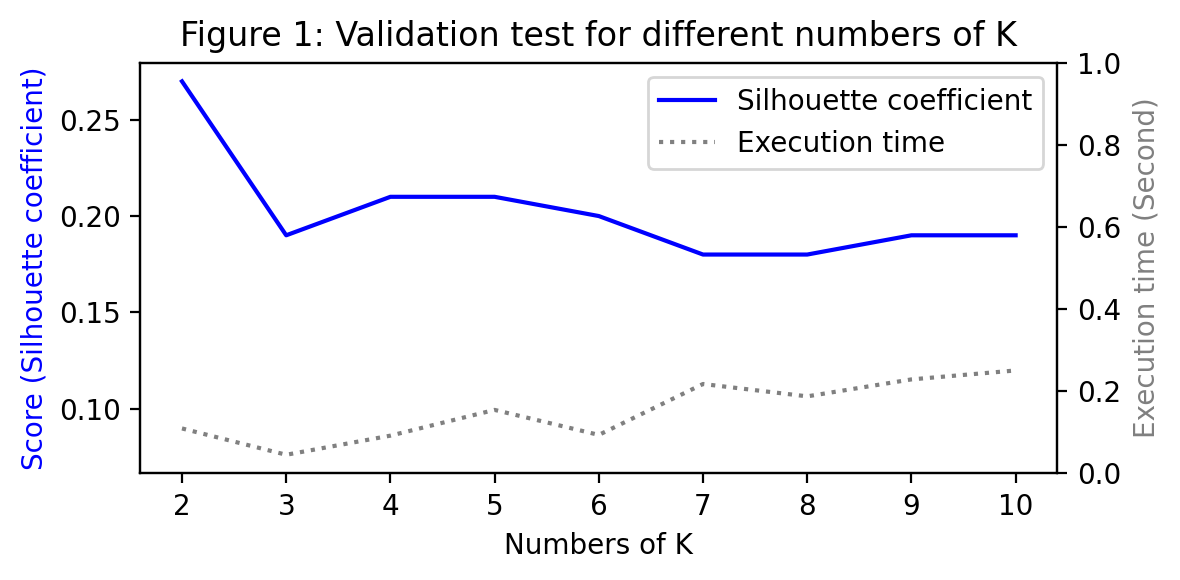

In [5]:
clusterer.kmeans_cluster_validation(data_set, clusterer.sklearn_kmeans, 10, verbose=False, figno="Figure 1: ")

### 1.2.3 Observation
- The highest positive silhouette coefficient 0.27 is acquired for k=2
- The next highest positive Silhouette coefficient is acquired for k=4
- To find the interesting subgroups within the data, k=4 is going to be used instead of k=2 for the K-means clustering. 

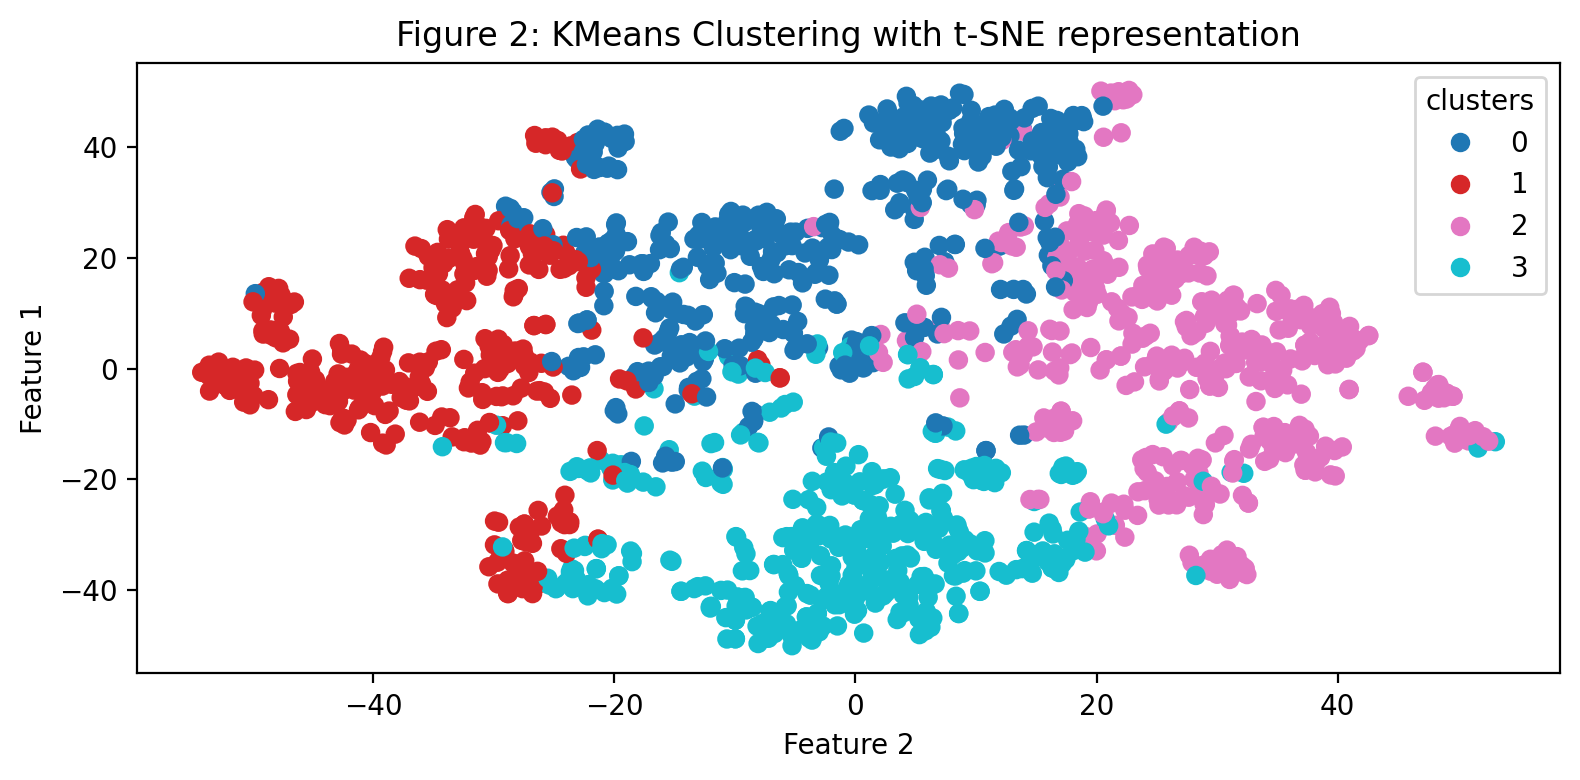

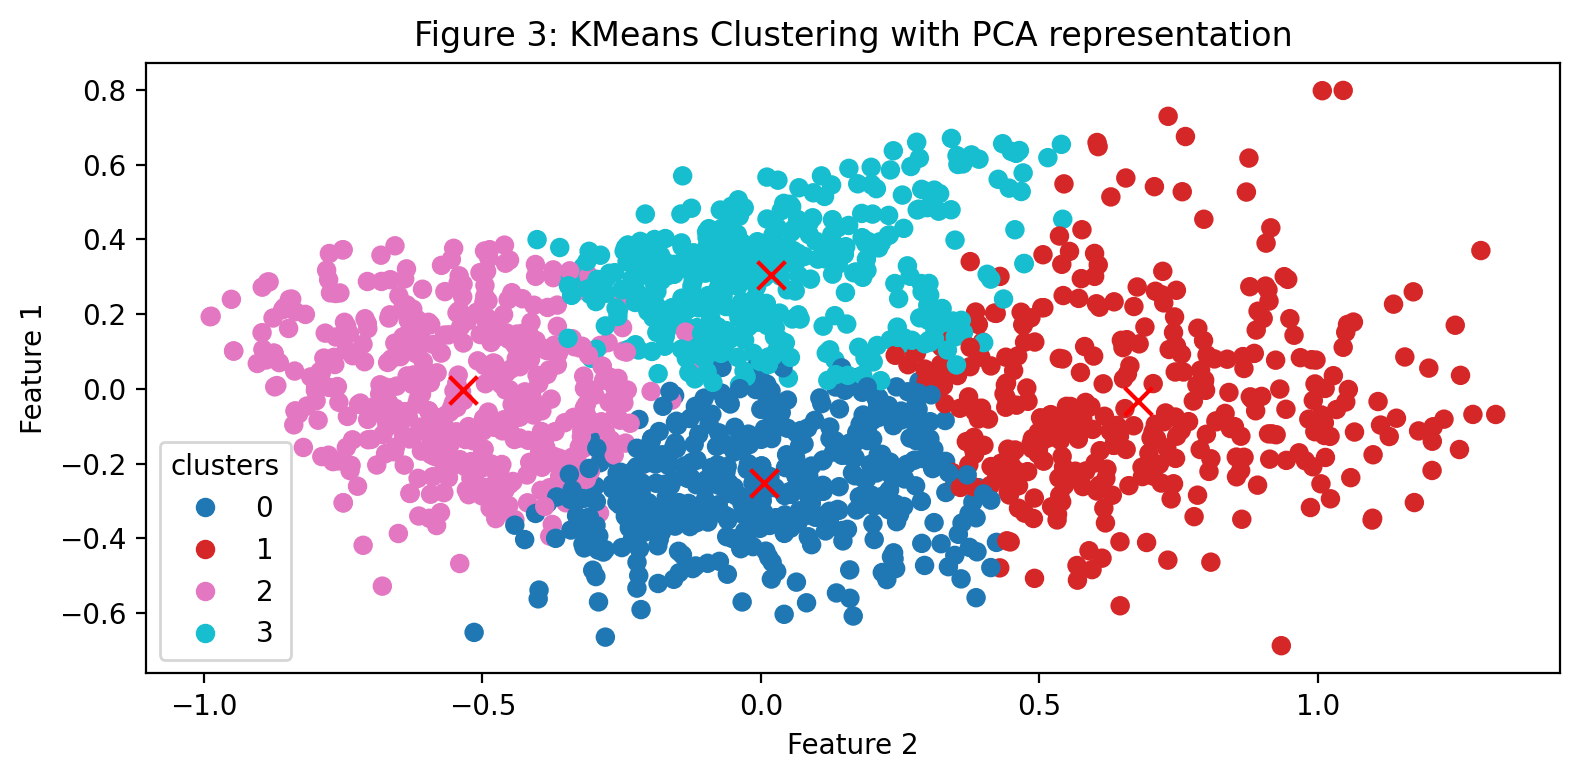

In [6]:
kmeans, memberships, internal_validity_score = clusterer.sklearn_kmeans(data_set, k=4)


transformed_tsne_input = file_processor.data_representation_TSNE(data_set)
clusterer.plot_kmeans_cluster(transformed_tsne_input, memberships, representation="with t-SNE representation", figno="Figure 2: ")

pca, transformed_pca_input = file_processor.pca_transform_data(x_train=data_set, n_comp=2)
transformed_cluster_centroid = file_processor.pca_transform_data(n_comp=2, eval_pca=False, x_test=kmeans.cluster_centers_, trained_pca= pca)
clusterer.plot_kmeans_cluster(transformed_pca_input, memberships, transformed_cluster_centroid, centroid=True, representation="with PCA representation", figno="Figure 3: ")

#### 1.2.4 Observation
- From figure 3 and figure 4 it can be seen that the four cluster and their centroids (red cross marks in figure 4) are well separated from each other while the within cluster distance among the points are relatively less. 

# 2. Good Performance

### 2.1 Generating small binary dataset (with bit size 50) and saving to test.csv

In [8]:
test_data =[]
bit_length = 50
test = np.ones(bit_length)
test_data.append(test)
for i in range(len(test)):
    temp = test.copy()
    for j in range(i+1):
        temp[j]=0
    test_data.append(temp)
# print(test_data)
column = [str(i) for i in range(bit_length)]
df = file_processor.numpy_to_panda(test_data, column)
df.head(11)
save_file_name = '../output/test.csv'
df.to_csv(save_file_name)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### 2.2 Selecting best k and distance metrics for the implemented k-means through internal validation (WSSS) on test.csv

##############################
Hamming distance
##############################
Best k for Kmeans: 20
Best WSSS: 148.0
##############################


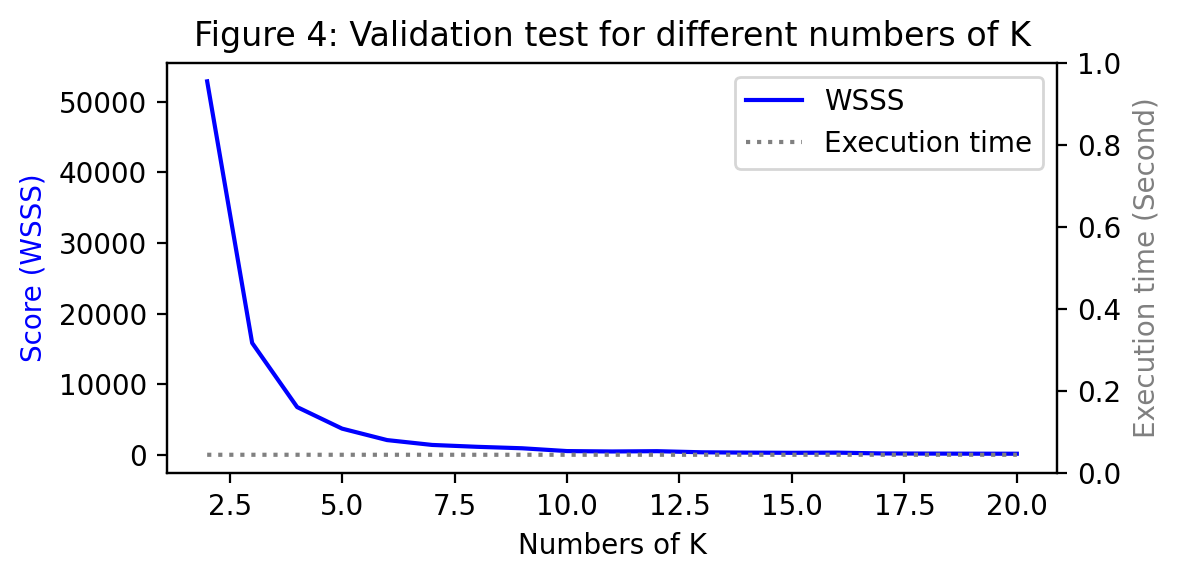

##############################
Eucildian Distance
##############################
Best k for Kmeans: 20
Best WSSS: 79.63
##############################


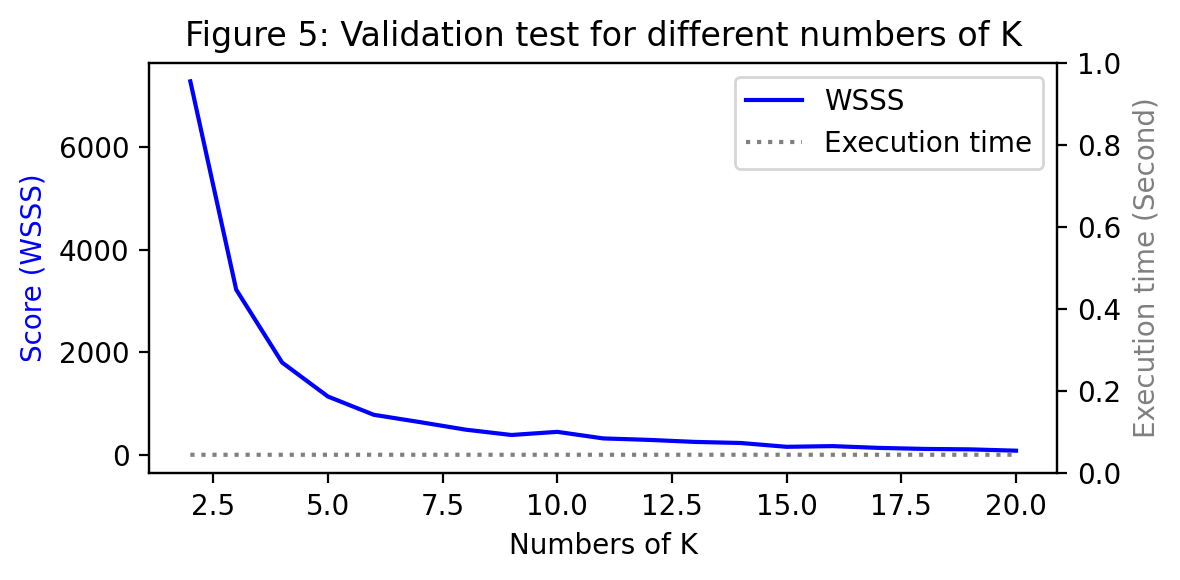

##############################
Shape Difference Distance
##############################
Best k for Kmeans: 6
Best WSSS: 0.01
##############################


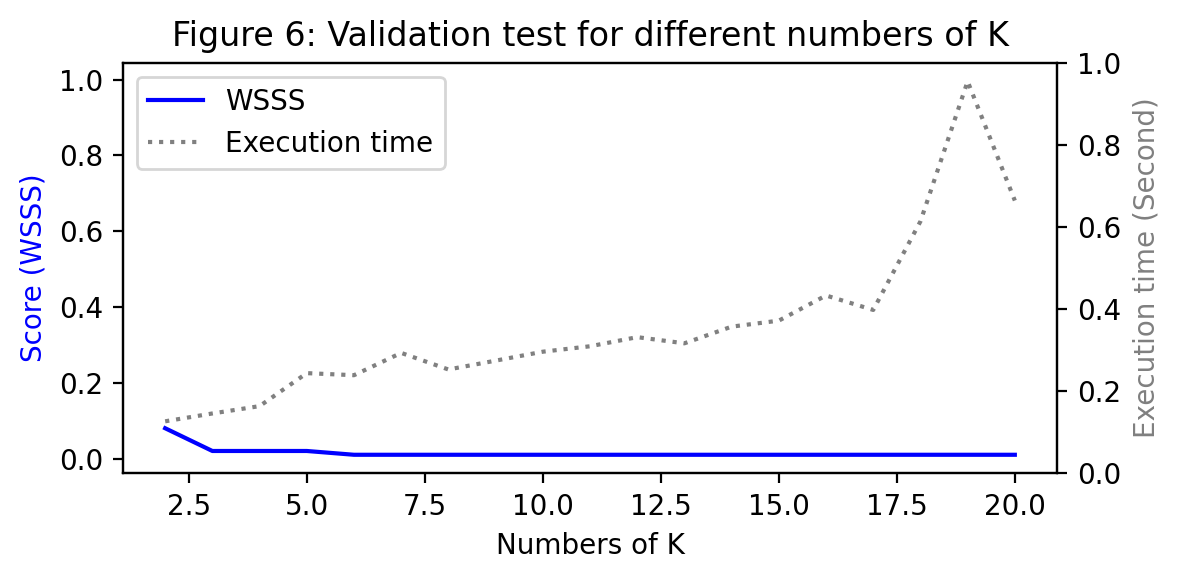

##############################
Gower Legendre
##############################
Best k for Kmeans: 16
Best WSSS: 0.02
##############################


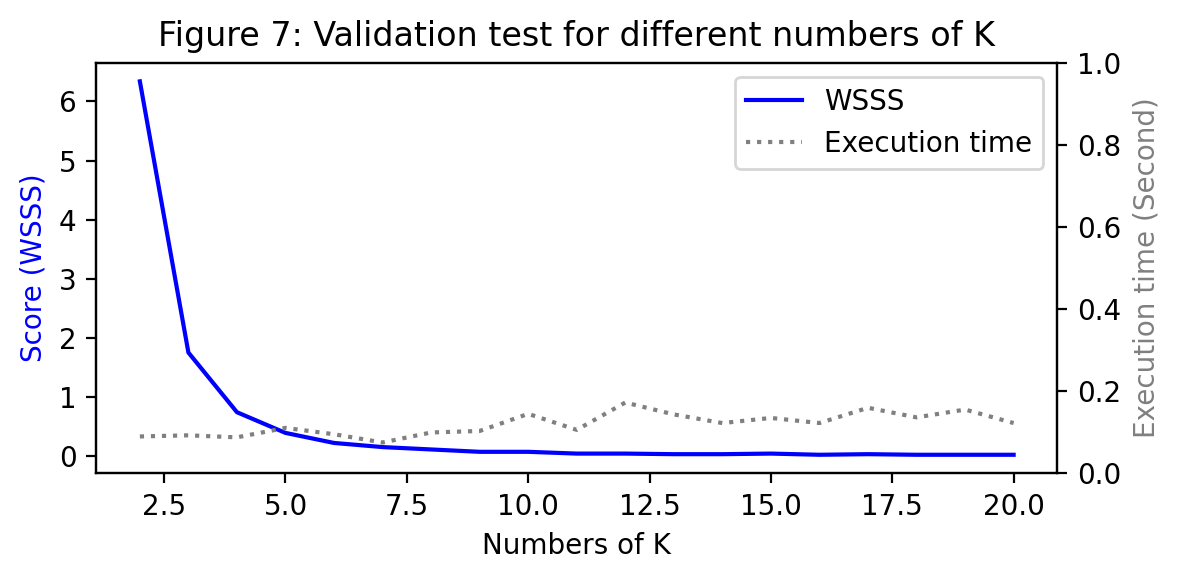

In [11]:
name_of_dm = ['Hamming distance', 'Eucildian Distance', 'Shape Difference Distance', 'Gower Legendre']
distance_metrics_vec = [distance_metrics.hamming, distance_metrics.euclid, distance_metrics.shape_difference, distance_metrics.gower_legendre]
for i, dm in enumerate(distance_metrics_vec):
    print('#'*30)
    print(name_of_dm[i])
    figure = "Figure {}: ".format(i+4)
    clusterer.kmeans_cluster_validation(df, k_range=20, verbose=False, kmode=True,kmode_diss=dm, objective='min', figno=figure)

#### 2.2.1 Observation
- From the above figure (4-7) the best WSSS was obtained for shape difference metrics with k=6. 
- Considering the computational cost we can see that Gower Legendre distance metrics provide reasonable WSSS at k=6 and thus next kmeans clustering has been applied to the test.csv data with k=6 and Gower Legendre distance metric. 

### 2.3 Applying implemented K-means with k=6 and Gower Legendre distance metrics on test.csv

####################
Gower Legendre
Cluster Memebership:
	cluster 0: 8
	cluster 1: 10
	cluster 2: 5
	cluster 3: 10
	cluster 4: 7
	cluster 5: 11
WSSS: 0.27690395902456033
####################


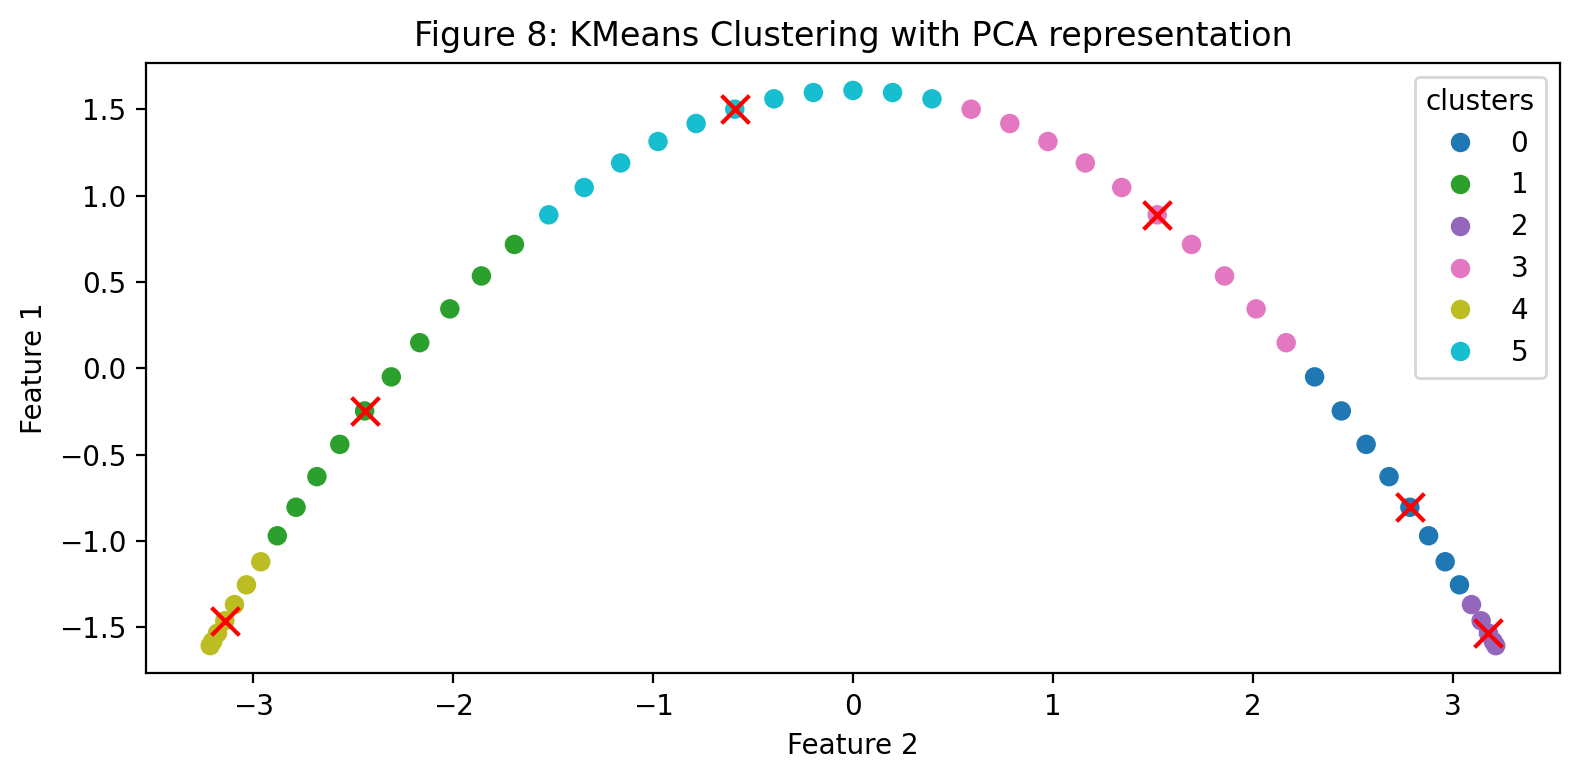

In [15]:
Selected_distance_metrics = 3 
best_k = 6
dm = distance_metrics_vec[Selected_distance_metrics]
kmodes = KModes(dm, n_clusters=best_k, n_init=5, init='random', verbose=0)
kmodes, memberships, WSSS = kmodes.fit(df)
print("#"*20)
print(name_of_dm[Selected_distance_metrics])
print("Cluster Memebership:")
cl, counts = np.unique(memberships, return_counts=True)
for i in range(0, len(cl)):
    print('\tcluster ' + str(cl[i]) + ': ' + str(counts[i]))
print("WSSS:", np.sum(WSSS))
print("#"*20)
    
pca, transformed_pca_input = file_processor.pca_transform_data(x_train=df, n_comp=2, eval_pca=True)
transformed_cluster_centroid = file_processor.pca_transform_data(n_comp=2, eval_pca=False, x_test=kmodes._enc_cluster_centroids, trained_pca= pca)
clusterer.plot_kmeans_cluster(transformed_pca_input, memberships, transformed_cluster_centroid, centroid=True, representation="with PCA representation", figno="Figure 8: ")

# 3 Excellent Performance

### 3.1 Parsing maccs files from assignement 2 
The parsed maccs files are saved as .csv format to directory ='../output/processed_macckeys'

In [26]:
directory_path = '../../assignment2/data'
save_directory = '../output/processed_macckeys'
file_processor.parse_files_in_directory(directory_path, save_directory)

### 3.2 Executing the k-means clustering workflow 
- Using k=2
- Distance metrics = Gower Legendre
- Cluster result is saved to the directory '../output/macckeys_results'

In [6]:
!python cluster_workflow.py --kmode True --k 2 --datasets '../output/processed_macckeys' --distance_metrics 'gl' --transformation pca

Figure(1600x800)
Figure(1600x800)
Figure(1600x800)
Figure(1600x800)
Figure(1600x800)
Figure(1600x800)
Figure(1600x800)
Figure(1600x800)


### 3.3 Clustering Result 

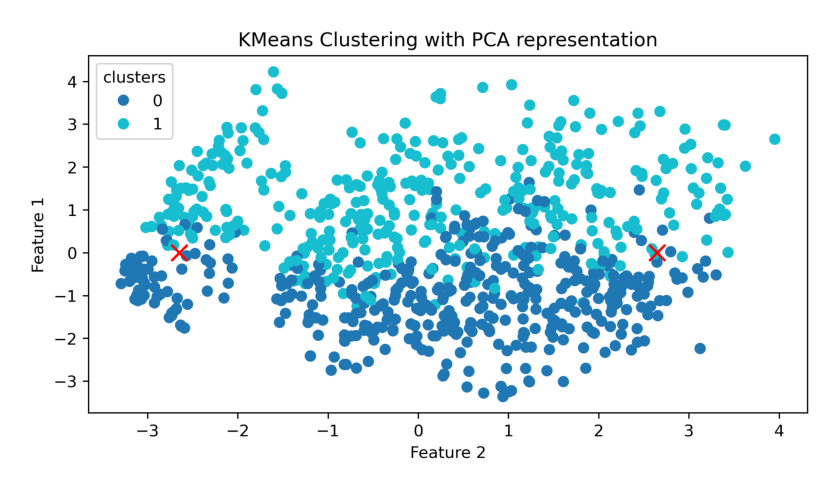

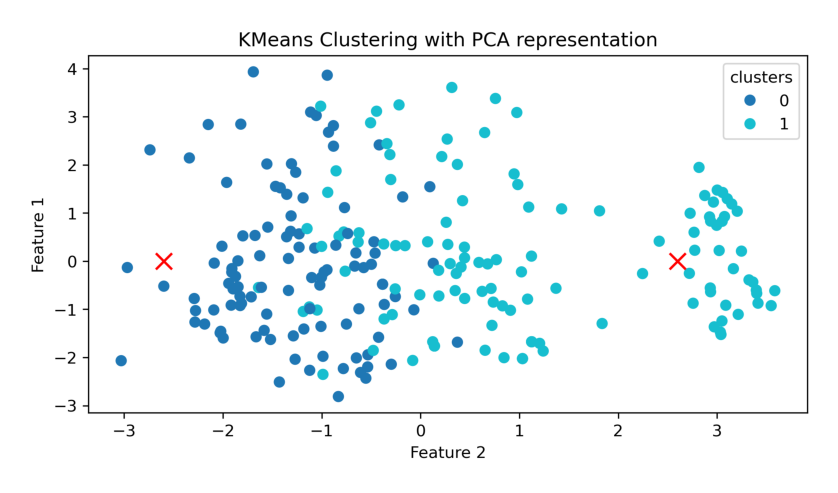

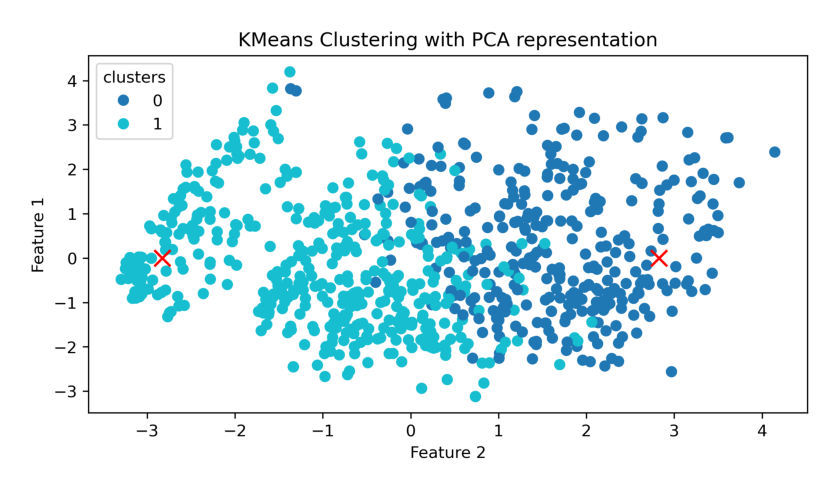

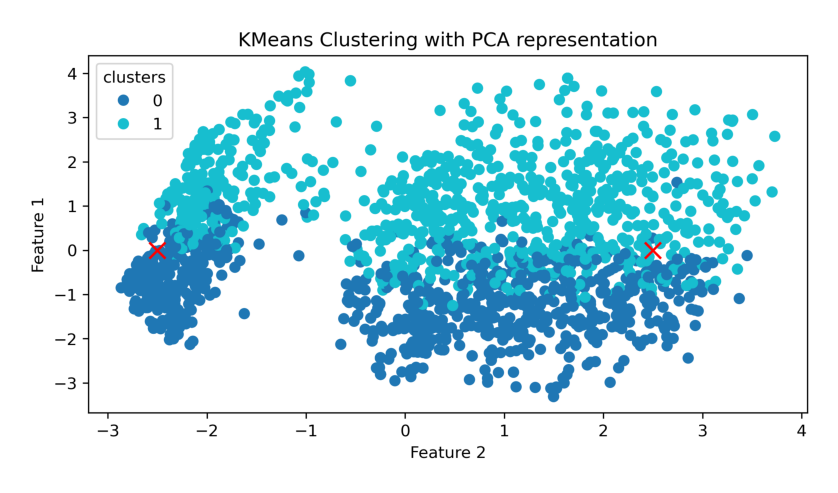

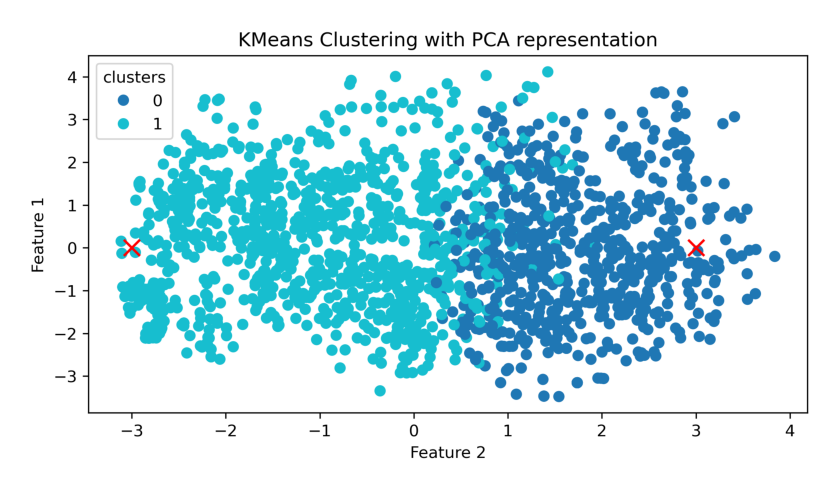

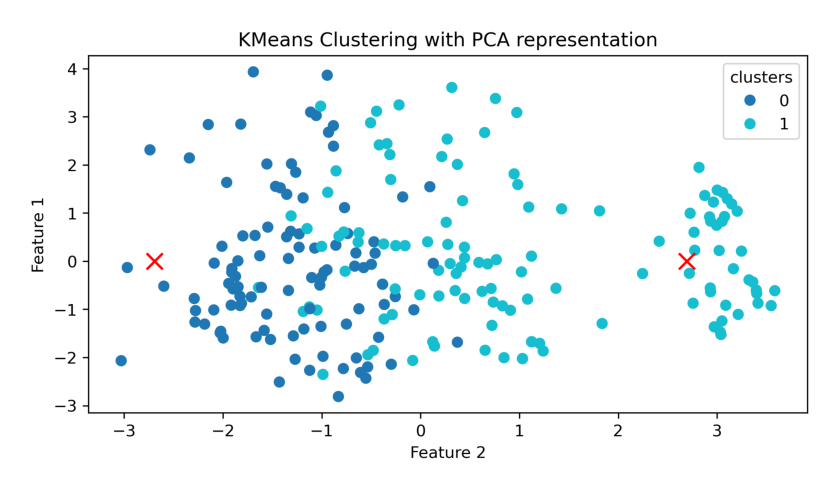

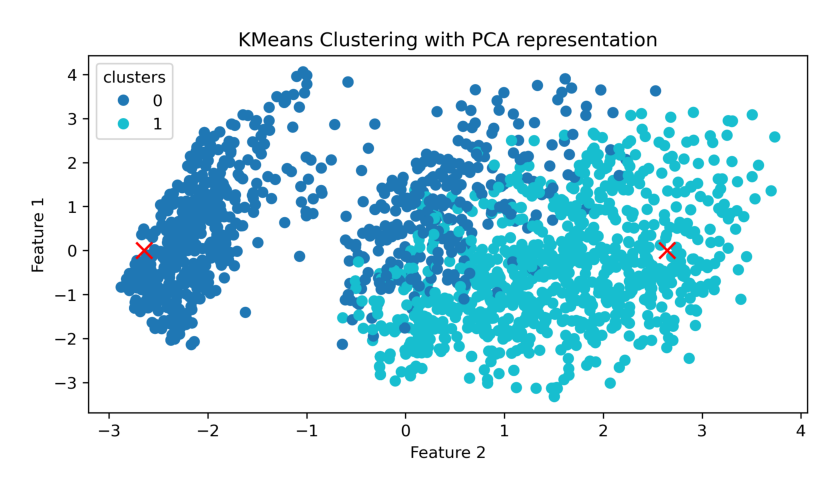

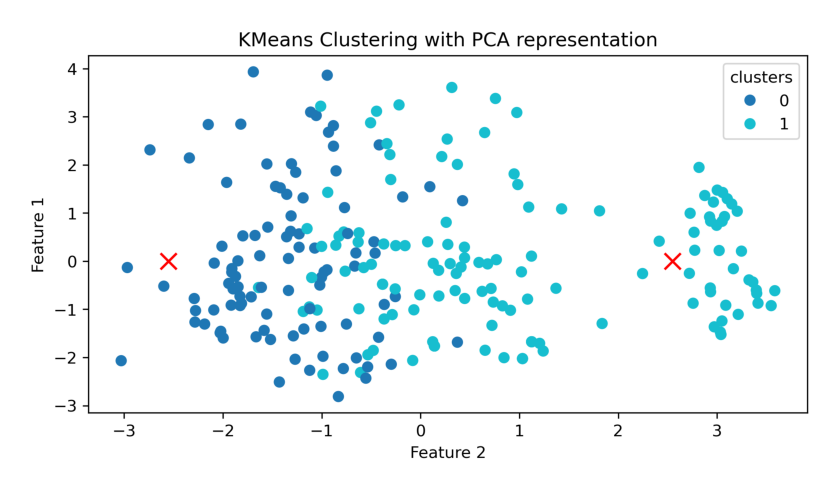

In [9]:
from matplotlib import image as mpimg
result_dir = '../output/macckeys_results'
for d in os.listdir(result_dir):
    plot_file = os.path.join(result_dir, d)
    plt.figure(figsize=(6,3), dpi=200)
    im = mpimg.imread(plot_file)
    plt.axis('off')
    plt.imshow(im)

# 4 Exceptional Performance

### 4.1 Processing u.data

In [10]:
# read in the data and take a quick look at it
dataset = pd.read_csv('../data/u.data', sep="\t", header=None, engine='python')
dataset.columns = ["user_id", "item_id", "rating", "timestamp"]

display(dataset.head())
display(dataset.shape)
dataset.drop(["timestamp"], axis=1, inplace=True)
display(dataset['rating'].value_counts())

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


(100000, 4)

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

In [5]:
# one-hot encode the features and have a look at the transformed data 
data_one_hot = pd.get_dummies(dataset.iloc[0:100000,:], columns=['user_id', 'item_id', 'rating'])
data_one_hot.shape

(100000, 2630)

### 4.2 Execution time with sklearn k-means implementation with Euclidian distance metric

In [16]:
import time
num_clusters = 2
start = time.time()
kmeans, memberships, internal_validity_score = clusterer.sklearn_kmeans(data_one_hot, k=num_clusters)
end = time.time()
duration = round(end-start, 2)
print('Silhouette coefficient with k=' + str(num_clusters) + ": " + str(round(internal_validity_score, 2)))
print('Number of instances in clusters:')
cl, counts = np.unique(memberships, return_counts=True)
for i in range(0, len(cl)):
    print('\tcluster ' + str(cl[i]) + ': ' + str(counts[i]))
print("Clustering took: " + str(duration) + " secs")

Silhouette coefficient with k=2: 0.1
Number of instances in clusters:
	cluster 0: 65826
	cluster 1: 34174
Clustering took: 865.93 secs


#### 4.2.1 Observation
- We can see that the execution time for sklearn implementation of kmeans with Euclidian distance metrics on 100000 instances from u.data dataset is 865.93 seconds = 14.41 minutes

### 4.3 Improving execution time of sklearn k-means implementation with different sparse matrix

In [13]:
def execute_clustering(data_one_hot_sparse, num_clusters):
    num_clusters = 2
    
    start = time.time()
    kmeans, memberships, internal_validity_score = clusterer.sklearn_kmeans(data_one_hot_sparse, k=num_clusters)
    end = time.time()
    
    duration = round(end-start, 2)
    print('Silhouette coefficient with k=' + str(num_clusters) + ": " + str(round(internal_validity_score, 2)))
    print('Number of instances in clusters:')
    cl, counts = np.unique(memberships, return_counts=True)
    for i in range(0, len(cl)):
        print('\tcluster ' + str(cl[i]) + ': ' + str(counts[i]))
    print("Clustering took: " + str(duration) + " secs")
    return duration

In [17]:
import scipy.sparse as sp
sparse_mat_name = ['get_dummies_default','CSC','CSR', 'BSR', 'DOK', 'LIL', 'COO', 'DIA']
num_clusters = 2
print('#'*30)
print('Sparse Matrix:', sparse_mat_name[0])
data_one_hot_default = pd.get_dummies(dataset.iloc[0:100000,:], columns=['user_id', 'item_id', 'rating'], sparse=True)
best_d  = execute_clustering(data_one_hot_default, num_clusters)
print('#'*30)
data_one_hot = pd.get_dummies(dataset.iloc[0:100000,:], columns=['user_id', 'item_id', 'rating'])
sparse_mat = [sp.csc_matrix ,sp.csr_matrix, sp.bsr_matrix, sp.dok_matrix, sp.lil_matrix, sp.coo_matrix, sp.dia_matrix]

best_idx=0
for i, sp_m in enumerate(sparse_mat):
    print('#'*30)
    print('Sparse Matrix:', sparse_mat_name[i+1])
    data_one_hot_sparse = sp_m(data_one_hot)
    d = execute_clustering(data_one_hot_sparse, num_clusters)
    print('#'*30)
    if best_d>=d:
        best_d=d
        best_idx=i+1
print('#'*30)
print('Fastest sparse datastructure is:', sparse_mat_name[best_idx])
print('Duration (sec):', best_d)

##############################
Sparse Matrix: get_dummies_default
Silhouette coefficient with k=2: 0.1
Number of instances in clusters:
	cluster 0: 65826
	cluster 1: 34174
Clustering took: 113.81 secs
##############################
##############################
Sparse Matrix: CSC
Silhouette coefficient with k=2: 0.1
Number of instances in clusters:
	cluster 0: 65826
	cluster 1: 34174
Clustering took: 112.71 secs
##############################
##############################
Sparse Matrix: CSR
Silhouette coefficient with k=2: 0.1
Number of instances in clusters:
	cluster 0: 65826
	cluster 1: 34174
Clustering took: 115.8 secs
##############################
##############################
Sparse Matrix: BSR
Silhouette coefficient with k=2: 0.1
Number of instances in clusters:
	cluster 0: 65826
	cluster 1: 34174
Clustering took: 136.05 secs
##############################
##############################
Sparse Matrix: DOK
Silhouette coefficient with k=2: 0.1
Number of instances in clusters:
	

#### 4.3.1 Observation:
- By using different sparse data structures for the one hot encoding the execution time can be significantly improved. 
- Here we can observe the execution time for different sparse matrices and among them, sparse matrix with compressed sparse column (CSC) seems to provide the fastest execution time of 112.71 seconds = 1.87 minutes. Which is almost 8 times faster than the earlier sklearn k-means implementation that took 14.4 minutes for clustering. 